# Topic Modeling: Financial News

This notebook contains an example of LDA applied to financial news articles.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from collections import Counter
from pathlib import Path
import logging

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# spacy for language processing
import spacy

# sklearn for feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# gensim for topic models
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

# topic model viz
import pyLDAvis
from pyLDAvis.gensim_models import prepare

In [3]:
sns.set_style('white')
pyLDAvis.enable_notebook()

In [4]:
stop_words = set(pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words',
                             header=None,
                             squeeze=True).tolist())

## Helper Viz Functions

In [6]:
def show_word_list(model, corpus, top=10, save=False):
    top_topics = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    words, probs = [], []
    for top_topic, _ in top_topics:
        words.append([t[1] for t in top_topic[:top]])
        probs.append([t[0] for t in top_topic[:top]])

    fig, ax = plt.subplots(figsize=(model.num_topics*1.2, 5))
    sns.heatmap(pd.DataFrame(probs).T,
                annot=pd.DataFrame(words).T,
                fmt='',
                ax=ax,
                cmap='Blues',
                cbar=False)
    fig.tight_layout()
    if save:
        fig.savefig(f'fin_news_wordlist_{top}', dpi=300)

In [7]:
def show_coherence(model, corpus, tokens, top=10, cutoff=0.01):
    top_topics = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    word_lists = pd.DataFrame(model.get_topics().T, index=tokens)
    order = []
    for w, word_list in word_lists.items():
        target = set(word_list.nlargest(top).index)
        for t, (top_topic, _) in enumerate(top_topics):
            if target == set([t[1] for t in top_topic[:top]]):
                order.append(t)

    fig, axes = plt.subplots(ncols=2, figsize=(15,5))
    title = f'# Words with Probability > {cutoff:.2%}'
    (word_lists.loc[:, order]>cutoff).sum().reset_index(drop=True).plot.bar(title=title, ax=axes[1]);

    umass = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    pd.Series([c[1] for c in umass]).plot.bar(title='Topic Coherence', ax=axes[0])
    fig.tight_layout()
    fig.savefig(f'fin_news_coherence_{top}', dpi=300);

In [8]:
def show_top_docs(model, corpus, docs):
    doc_topics = model.get_document_topics(corpus)
    df = pd.concat([pd.DataFrame(doc_topic, 
                                 columns=['topicid', 'weight']).assign(doc=i) 
                    for i, doc_topic in enumerate(doc_topics)])

    for topicid, data in df.groupby('topicid'):
        print(topicid, docs[int(data.sort_values('weight', ascending=False).iloc[0].doc)])
        print(pd.DataFrame(lda.show_topic(topicid=topicid)))

## Load Financial News

The data is avaialble from [Kaggle](https://www.kaggle.com/jeet2016/us-financial-news-articles). 

Download and unzip into data directory in repository root folder, then rename the enclosing folder to `us-financial-news` and the subfolders so you get the following directory structure:
```
data
  |-us-financial-news
     |-2018_01
     |-2018_02
     |-2018_03
     |-2018_04
     |-2018_05
```

In [ ]:
data_path = Path('..', 'data', 'us-financial-news')

We limit the article selection to the following sections in the dataset:

In [9]:
section_titles = ['Press Releases - CNBC',
                  'Reuters: Company News',
                  'Reuters: World News',
                  'Reuters: Business News',
                  'Reuters: Financial Services and Real Estate',
                  'Top News and Analysis (pro)',
                  'Reuters: Top News',
                  'The Wall Street Journal &amp; Breaking News, Business, Financial and Economic News, World News and Video',
                  'Business &amp; Financial News, U.S &amp; International Breaking News | Reuters',
                  'Reuters: Money News',
                  'Reuters: Technology News']

In [10]:
def read_articles():
    articles = []
    counter = Counter()
    for f in data_path.glob('*/**/*.json'):
        article = json.load(f.open())
        if article['thread']['section_title'] in set(section_titles):
            text = article['text'].lower().split()
            counter.update(text)
            articles.append(' '.join([t for t in text if t not in stop_words]))
    return articles, counter

In [11]:
articles, counter = read_articles()
print(f'Done loading {len(articles):,.0f} articles')

Done loading 125,964 articles


In [12]:
most_common = (pd.DataFrame(counter.most_common(), columns=['token', 'count'])
               .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)]))

In [13]:
most_common.head(10)

,token,count
8,$,592548
17,net,317060
18,),315742
23,million,269721
25,-,258943
26,income,257158
31,2018,227890
32,said,217339
33,%,214997
34,company,213316


## Preprocessing with SpaCy

In [24]:
results_path = Path('results', 'financial_news')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [14]:
def clean_doc(d):
    doc = []
    for t in d:
        if not any([t.is_stop, t.is_digit, not t.is_alpha, t.is_punct, t.is_space, t.lemma_ == '-PRON-']):        
            doc.append(t.lemma_)
    return ' '.join(doc)    

In [15]:
nlp = spacy.load('en')
nlp.max_length = 6000000
nlp.disable_pipes('ner')

[('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f7b43da6fa0>)]

In [16]:
nlp.pipe_names

['tagger', 'parser']

In [17]:
def preprocess(articles):
    iter_articles = (article for article in articles)
    clean_articles = []
    for i, doc in enumerate(nlp.pipe(iter_articles, 
                                     batch_size=100, 
                                     n_threads=8), 1):
        if i % 1000 == 0:
            print(f'{i / len(articles):.2%}', end=' ', flush=True)
        clean_articles.append(clean_doc(doc))
    return clean_articles

In [18]:
clean_articles = preprocess(articles)

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/spacy/language.py:771: DeprecationWarning: [W016] The keyword argument `n_threads` is now deprecated. As of v2.2.2, the argument `n_process` controls parallel inference via multiprocessing.
  warnings.warn(Warnings.W016, DeprecationWarning)


0.79% 1.59% 2.38% 3.18% 3.97% 4.76% 5.56% 6.35% 7.14% 7.94% 8.73% 9.53% 10.32% 11.11% 11.91% 12.70% 13.50% 14.29% 15.08% 15.88% 16.67% 17.47% 18.26% 19.05% 19.85% 20.64% 21.43% 22.23% 23.02% 23.82% 24.61% 25.40% 26.20% 26.99% 27.79% 28.58% 29.37% 30.17% 30.96% 31.76% 32.55% 33.34% 34.14% 34.93% 35.72% 36.52% 37.31% 38.11% 38.90% 39.69% 40.49% 41.28% 42.08% 42.87% 43.66% 44.46% 45.25% 46.04% 46.84% 47.63% 48.43% 49.22% 50.01% 50.81% 51.60% 52.40% 53.19% 53.98% 54.78% 55.57% 56.37% 57.16% 57.95% 58.75% 59.54% 60.33% 61.13% 61.92% 62.72% 63.51% 64.30% 65.10% 65.89% 66.69% 67.48% 68.27% 69.07% 69.86% 70.66% 71.45% 72.24% 73.04% 73.83% 74.62% 75.42% 76.21% 77.01% 77.80% 78.59% 79.39% 80.18% 80.98% 81.77% 82.56% 83.36% 84.15% 84.94% 85.74% 86.53% 87.33% 88.12% 88.91% 89.71% 90.50% 91.30% 92.09% 92.88% 93.68% 94.47% 95.27% 96.06% 96.85% 97.65% 98.44% 99.23% 

In [19]:
clean_path = results_path / 'clean_text'
clean_path.write_text('\n'.join(clean_articles))

333868354

## Vectorize data

In [20]:
docs = clean_path.read_text().split('\n')
len(docs)

125964

### Explore cleaned data

In [21]:
article_length, token_count = [], Counter()
for i, doc in enumerate(docs, 1):
    if i % 1e6 == 0:
        print(i, end=' ', flush=True)
    d = doc.lower().split()
    article_length.append(len(d))
    token_count.update(d)

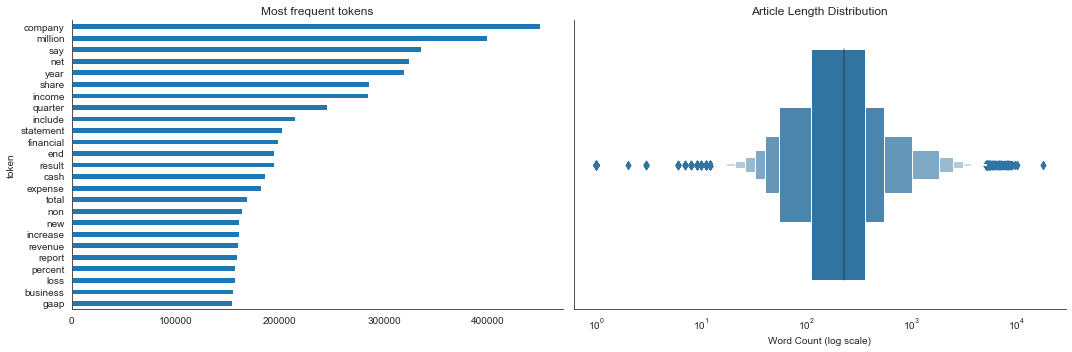

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
(pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
 .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)])
 .set_index('token')
 .squeeze()
 .iloc[:25]
 .sort_values()
 .plot
 .barh(ax=axes[0], title='Most frequent tokens'))
sns.boxenplot(x=pd.Series(article_length), ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_xlabel('Word Count (log scale)')
axes[1].set_title('Article Length Distribution')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'fn_explore', dpi=300);

In [26]:
pd.Series(article_length).describe(percentiles=np.arange(.1, 1.0, .1))

count    125964.000000
mean        354.514091
std         534.782734
min           1.000000
10%          48.000000
20%          85.000000
30%         135.000000
40%         180.000000
50%         225.000000
60%         267.000000
70%         324.000000
80%         413.000000
90%         622.000000
max       17838.000000
dtype: float64

In [27]:
docs = [x.lower() for x in docs]

In [28]:
docs[3]

'washington reuters treasury secretary steven mnuchin tuesday say want know consumer financial protection bureau handling probe hack credit bureau equifax report agency acting director pull investigate matter equifax disclose september hacker steal personal datum collect million americans monday reuters report act cfpb chief mick mulvaney brakes agency equifax investigation speak director mulvaney mnuchin tell house representatives financial services committee go discuss tuesday cfpb say examine equifax breach decline detail bureau look equifax datum breach response agency say statement reuters cite people familiar matter report monday cfpb open investigation equifax mulvaney rein work begin predecessor richard cordray mulvaney order subpoenas equifax seek swear testimony executive routine step scale probe source say add cfpb shelve plan ground test equifax protect datum idea back cordray cfpb recently rebuff bank regulator federal reserve federal deposit insurance corp office comptrol

### Set vocab parameters

In [29]:
min_df = .005
max_df = .1
ngram_range = (1, 1)
binary = False

In [30]:
vectorizer = TfidfVectorizer(stop_words='english',
                             min_df=min_df,
                             max_df=max_df,
                             ngram_range=ngram_range,
                             binary=binary)
dtm = vectorizer.fit_transform(docs)
tokens = vectorizer.get_feature_names()
dtm.shape

(125964, 3736)

In [31]:
corpus = Sparse2Corpus(dtm, documents_columns=False)
id2word = pd.Series(tokens).to_dict()
dictionary = Dictionary.from_corpus(corpus, id2word)

## Train & Evaluate LDA Model

In [32]:
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.DEBUG)
logging.root.level = logging.DEBUG

### Train models with 5-25 topics

In [33]:
num_topics = [5, 10, 15, 20]

In [36]:
for topics in num_topics:
    print(topics)
    lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=topics,
                     chunksize=len(docs),
                     update_every=1,
                     alpha='auto',                     # a-priori belief for the each topics' probability
                     eta='auto',                       # a-priori belief on word probability
                     decay=0.5,                        # percentage of previous lambda value forgotten
                     offset=1.0,
                     eval_every=1,
                     passes=10,
                     iterations=50,
                     gamma_threshold=0.001,
                     minimum_probability=0.01,         # filter topics with lower probability
                     minimum_phi_value=0.01,           # lower bound on term probabilities
                     random_state=42)
    lda_model.save((results_path / f'model_{topics}').as_posix())

5
10
15
20
25


### Evaluate results

We show results for one model using a vocabulary of 3,800 tokens based on min_df=0.1% and max_df=25% with a single pass to avoid length training time for 20 topics. We can use pyldavis topic_info attribute to compute relevance values for lambda=0.6 that produces the following word list 

In [37]:
def eval_lda_model(ntopics, model, corpus=corpus, tokens=tokens):
    show_word_list(model=model, corpus=corpus, top=ntopics, save=True)
    show_coherence(model=model, corpus=corpus, tokens=tokens, top=ntopics)
    vis = prepare(model, corpus, dictionary, mds='tsne')
    pyLDAvis.save_html(vis, f'lda_{ntopics}.html')
    return 2 ** (-model.log_perplexity(corpus))

In [ ]:
lda_models = {}
perplexity ={}
for ntopics in num_topics:
    print(ntopics)
    lda_models[ntopics] = LdaModel.load((results_path / f'model_{ntopics}').as_posix())
    perplexity[ntopics] = eval_lda_model(ntopics=ntopics, model=lda_models[ntopics])

### Perplexity

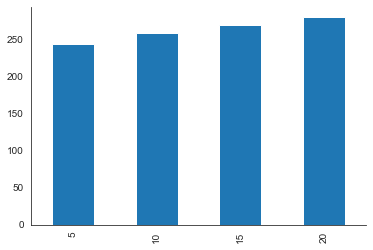

In [41]:
pd.Series(perplexity).plot.bar()
sns.despine();

### PyLDAVis for 15 Topics

In [42]:
vis = prepare(lda_models[15], corpus, dictionary, mds='tsne')
pyLDAvis.display(vis)

## LDAMultiCore Timing

In [43]:
df = pd.read_csv(results_path / 'lda_multicore_test_results.csv')
df.head()

,workers,num_topics,duration,test_perplexity
0,1,10,2035.206371,72.621968
1,1,50,1611.578738,84.457663
2,4,10,1093.389884,72.742675
3,4,50,1067.982344,82.115884
4,8,10,1154.867700,72.791885


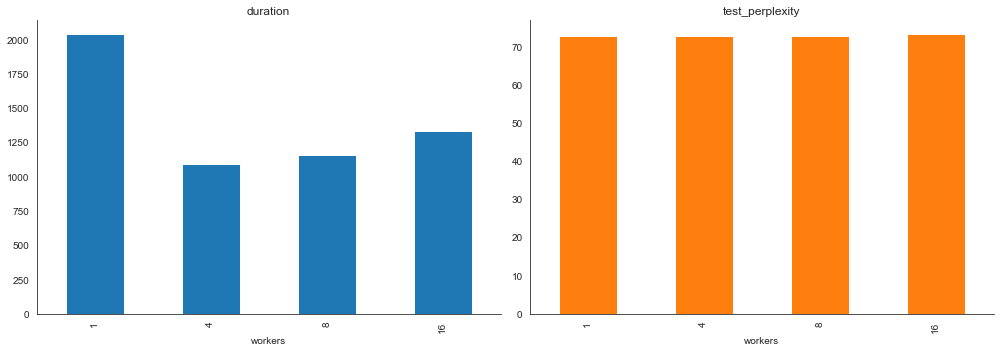

In [45]:
df[df.num_topics==10].set_index('workers')[['duration', 'test_perplexity']].plot.bar(subplots=True, layout=(1,2), figsize=(14,5), legend=False)
sns.despine()
plt.tight_layout();